In this notebook, we're going to construct a node2vec visualization using Gensim and a graph consisting of board members and companies listed at the S&P500.

In [ ]:
!pip install -q --upgrade gensim

     |████████████████████████████████| 24.2MB 124kB/s 


In [ ]:
!pip install -q --upgrade smart_open

In [ ]:
%tensorflow_version 2.x

import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from random import choice
import pandas as pd
import networkx as nx
import gensim
import re

In [ ]:
!wget http://mg.bluecourses.com/wp-content/uploads/2020/04/sp500.pkl -O sp500.pkl

--2020-07-21 10:36:42--  http://mg.bluecourses.com/wp-content/uploads/2020/04/sp500.pkl
Resolving mg.bluecourses.com (mg.bluecourses.com)... 46.30.215.75
Connecting to mg.bluecourses.com (mg.bluecourses.com)|46.30.215.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1004819 (981K)
Saving to: ‘sp500.pkl’

sp500.pkl           100%[===================>] 981.27K  4.36MB/s    in 0.2s    

2020-07-21 10:36:42 (4.36 MB/s) - ‘sp500.pkl’ saved [1004819/1004819]



Read in the data set using Pandas and show the first couple of rows.

In [ ]:
df = pd.read_pickle('sp500.pkl')
df['Name'] = df.apply(lambda x : x.Name.replace(x.Position, ''), axis=1)
df.head()

,symbol,Name,Age,Position,Appointed
0,MMM.N,Michael F. Roman,60,"Chairman of the Board, President, Chief Execut...",2019
1,MMM.N,Nicholas C. Gangestad,55,"Chief Financial Officer, Senior Vice President",2014
2,MMM.N,Paul A. Keel,50,Executive Vice President - Consumer Business G...,2019
3,MMM.N,Ashish K. Khandpur,52,Executive Vice President - Transportation and ...,2019
4,MMM.N,Mojdeh Poul,57,"Executive Vice President, Health Care Business...",2019


We need to construct a network out of this. Let's do so using `networkx`:

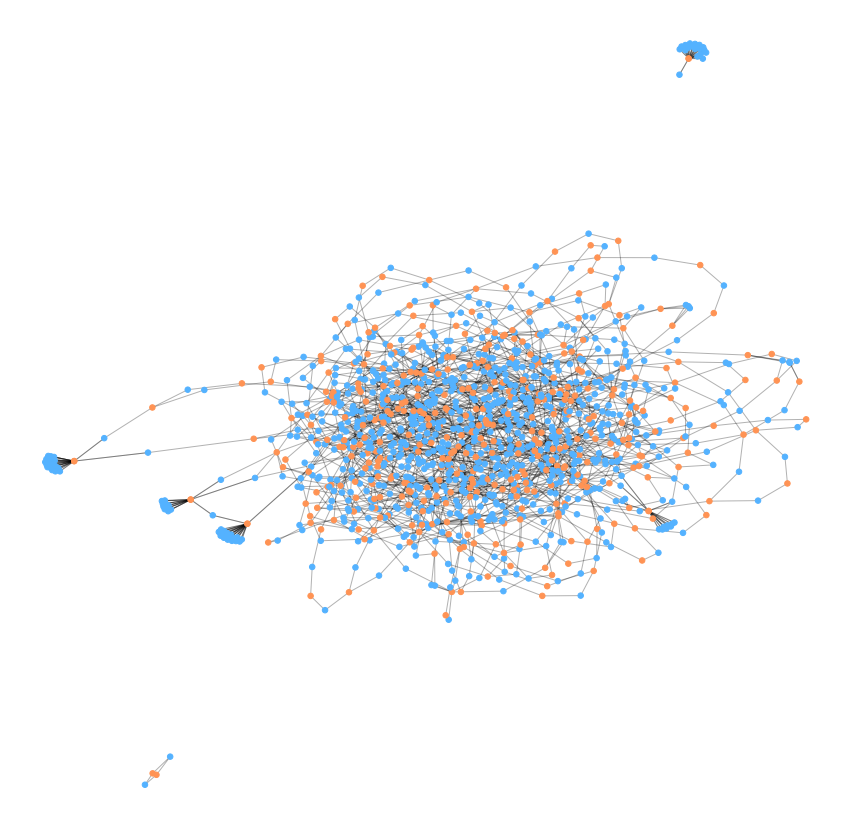

In [ ]:
G = nx.Graph()

for row in df.itertuples():
  G.add_node(row.symbol, type='company')
  G.add_node(row.Name,   type='officer')
  G.add_edge(row.symbol, row.Name)

while True:
  clean_nodes = [node for node, degree in dict(G.degree()).items() if degree <= 1]
  if not len(clean_nodes): break
  G.remove_nodes_from(clean_nodes)

node_color = ['#ff9354' if data['type'] == 'company' else '#54b2ff' for node, data in G.nodes(data=True)]

plt.subplots(figsize=(15,15))
nx.draw_spring(G, node_size=30, edge_color=(0,0,0,0.3), node_color=node_color)

We now define a function to generate a random walk:

In [ ]:
def generate_random_walk(G, stop_chance=0.05):
  node_list  = list( G.nodes(data=True) )
  sentence   = [choice(node_list)]
  neighbors  = list(nx.all_neighbors(G, sentence[-1][0]))
  while neighbors:
    neighbor   = choice(neighbors)
    neighbor   = [n for n in G.nodes(data=True) if n[0] == neighbor][0]
    sentence  += [neighbor]
    neighbors  = list(nx.all_neighbors(G, sentence[-1][0]))
    if np.random.random(1) < stop_chance:
      break
  return sentence

In [ ]:
generate_random_walk(G)

[('Leslie F. Seidman', {'type': 'officer'}),
 ('MCO.N', {'type': 'company'}),
 ('Kathryn M. Hill', {'type': 'officer'}),
 ('MCO.N', {'type': 'company'}),
 ('Vincent A. Forlenza', {'type': 'officer'}),
 ('BDX.N', {'type': 'company'}),
 ('R. Andrew Eckert', {'type': 'officer'}),
 ('VAR.N', {'type': 'company'}),
 ('Judy Bruner', {'type': 'officer'}),
 ('AMAT.OQ', {'type': 'company'}),
 ('Judy Bruner', {'type': 'officer'}),
 ('AMAT.OQ', {'type': 'company'}),
 ('Scott A. McGregor', {'type': 'officer'}),
 ('EFX.N', {'type': 'company'}),
 ('Scott A. McGregor', {'type': 'officer'}),
 ('EFX.N', {'type': 'company'}),
 ('Elane B. Stock', {'type': 'officer'}),
 ('EFX.N', {'type': 'company'}),
 ('Scott A. McGregor', {'type': 'officer'}),
 ('AMAT.OQ', {'type': 'company'}),
 ('Judy Bruner', {'type': 'officer'}),
 ('VAR.N', {'type': 'company'}),
 ('Judy Bruner', {'type': 'officer'}),
 ('STX.OQ', {'type': 'company'}),
 ('Judy Bruner', {'type': 'officer'}),
 ('STX.OQ', {'type': 'company'}),
 ('Stephen J

We then train word2vec on a corpus of random walks.

In [ ]:
num_walks = 10000

model     = gensim.models.Word2Vec(sentences=[
  [node[0] for node in generate_random_walk(G)] for i in range(num_walks)                                 
], size=32, window=4, min_count=0)

Just to make sure, we perform a check here that each node is included at least once in a random walk (and shows up in the vocabulary):

In [ ]:
# Make sure all nodes show up in the vocabulary
for node, data in G.nodes(data=True):
  assert node in model.wv.vocab, node

To visualize the graph, we perform a KMeans clustering:

In [ ]:
kmeans      = KMeans(n_clusters=4)
transformed = kmeans.fit_transform(model.trainables.syn1neg)
labels      = kmeans.labels_

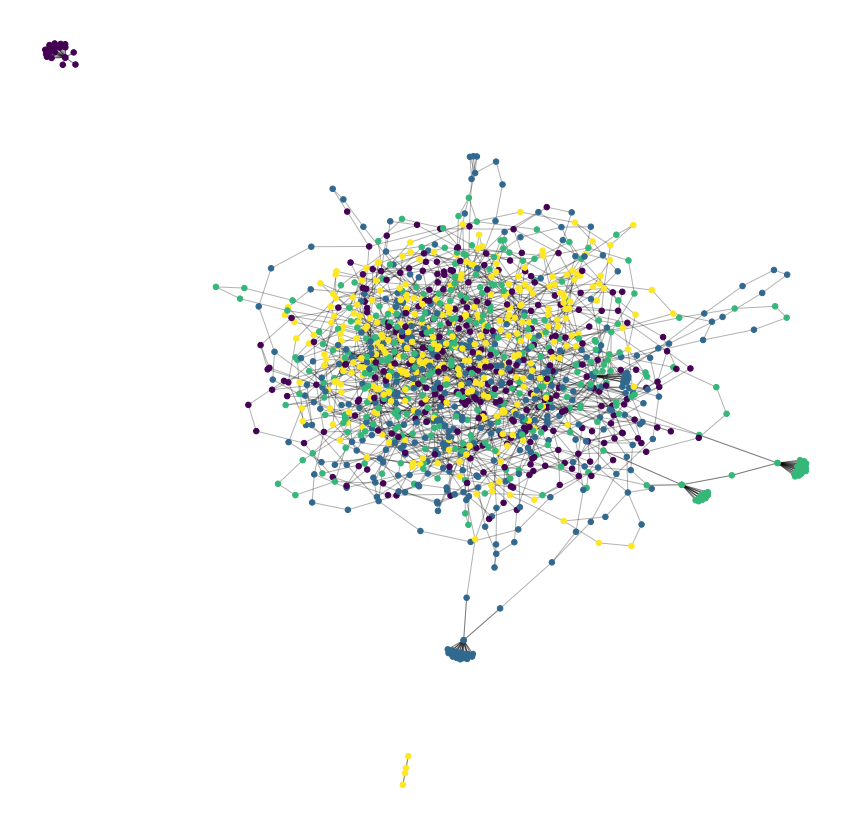

In [ ]:
node_color = [labels[model.wv.vocab[node].index] for node, data in G.nodes(data=True)]

plt.subplots(figsize=(15,15))
nx.draw_spring(G, node_size=30, edge_color=(0,0,0,0.3), node_color=node_color)

Things to try:

- Changing the way how random walks are performed (e.g. using node name versus node type, directed versus undirected, with our without edges as tokens, preventing to go backwards, ...), window size, embedding size and clustering technique and size can change the style of outcomes you get. Feel free to try this out which this or other graphs.